# Возможности Cython

Для сравнения производительности Python с Cython используем задачу: обход графа в ширину.

#### Граф для примера:

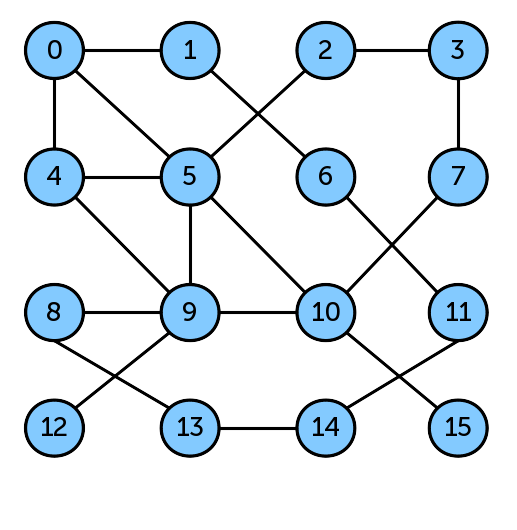

In [1]:
from IPython.display import Image
Image('BFS.png')

### Реализация на Python

Используем numpy массивы в силу их высокой скорости работы.

In [2]:
import numpy as np

Список смежности вершин:

In [3]:
adjacency = np.array([
    np.array([1, 4, 5]),         # 0
    np.array([0, 6]),            # 1
    np.array([3, 5]),            # 2
    np.array([2, 7]),            # 3
    np.array([0, 5, 9]),         # 4
    np.array([0, 2, 4, 9, 10]),  # 5
    np.array([1, 11]),           # 6
    np.array([3, 10]),           # 7
    np.array([9, 13]),           # 8
    np.array([4, 5, 10, 12]),    # 9
    np.array([5, 7, 9, 15]),     # 10
    np.array([6, 14]),           # 11
    np.array([9]),               # 12
    np.array([8, 14]),           # 13
    np.array([11, 13]),          # 14
    np.array([10])               # 15
])

Обход графа в ширину:

In [4]:
def bfs_python(graf, start, finish):
    n = graf.shape[0] # число вершин
    queue = np.array([]) # подготовим очередь
    queue = np.append(queue, start) # и поместим в нее исходную вершину
    used = np.array([False]*n) # горящие вершины
    parents = np.array([0]*n) # родительская вершина
    used[start] = True
    parents[start] = -1;
    # пока очередь не пуста
    while queue.shape[0] != 0:
        current = int(queue[0]) # берем элемент вначале очереди
        queue = np.delete(queue, 0)
        for i in range(graf[current].shape[0]): # осматриваем соседей
            to = graf[current][i]
            if used[to] != True: # если не заходили к ним,
                used[to] = True # заходим
                queue = np.append(queue, to) # ставим их в очередь
                parents[to] = current # запоминаем откуда пришли
    # Определение и вывод пути
    # из вершины start в вершину finish
    # включительно
    way = np.array([finish])
    while finish != start:
        finish = parents[finish]
        way = np.append(way, finish)
    return way

Проверим работу алгоритма:

In [5]:
print(*bfs_python(adjacency, 0, 15)[::-1])
print(*bfs_python(adjacency, 0, 12)[::-1])
print(*bfs_python(adjacency, 6, 12)[::-1])
print(*bfs_python(adjacency, 15, 3)[::-1])

0 5 10 15
0 4 9 12
6 1 0 4 9 12
15 10 7 3


Замерим скорость работы фушкции обхода графа:

In [6]:
%timeit bfs_python(adjacency, 6, 12)

842 µs ± 37.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Время работы 842 микросекунды.

### Реализация на Cython

In [7]:
%load_ext Cython

Для начала посмотрим в режиме анотации кода как Cython компилирует исходный код Python:

In [8]:
%%cython -a
import numpy as np
cimport numpy as np
cimport cython

def bfs_cython(graf, start, finish):
    n = graf.shape[0]
    queue = np.array([])
    queue = np.append(queue, start)
    used = np.array([False]*n)
    parents = np.array([0]*n)
    used[start] = True
    parents[start] = -1;   
    while queue.shape[0] != 0:
        current = int(queue[0])
        queue = np.delete(queue, 0)
        for i in range(graf[current].shape[0]):
            to = graf[current][i]
            if used[to] != True:
                used[to] = True
                queue = np.append(queue, to)
                parents[to] = current  
    way = np.array([finish])
    while finish != start:
        finish = parents[finish]
        way = np.append(way, finish)
    return way

Замерим скорость работы фушкции обхода графа на Cython:

In [9]:
%timeit bfs_cython(adjacency, 6, 12)

809 µs ± 9.17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Время работы 809 микросекунд. Улучшение производительности в 1.041раза.

### Опишем функцию согласно Cython

Посмотрим в режиме анотации кода:

In [10]:
%%cython -a
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.overflowcheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
def bfs_cython_type(np.ndarray graf, int start, int finish):
    cdef int n = graf.shape[0]
    cdef np.ndarray[np.int64_t, ndim=1] queue = np.array([], dtype=np.int64)
    cdef np.ndarray[np.uint8_t, ndim=1, cast=True] used = np.array(
        [False]*n, dtype=np.bool)
    cdef np.ndarray[np.int64_t, ndim=1] parents = np.array([0]*n, dtype=np.int64)
    queue = np.append(queue, start)
    used[start] = True
    parents[start] = -1;
    cdef int current, i, to
    while queue.shape[0] != 0:
        current = queue[0]
        queue = np.delete(queue, 0)
        for i in range(graf[current].shape[0]):
            to = graf[current][i]
            if used[to] != True:
                used[to] = True
                queue = np.append(queue, to)
                parents[to] = current
    cdef np.ndarray[np.int64_t, ndim=1] way = np.array([finish])
    while finish != start: 
        finish = parents[finish]
        way = np.append(way, finish) 
    return way

Замерим скорость работы фушкции обхода графа на Cython:

In [11]:
%timeit bfs_cython_type(adjacency, 6, 12)

664 µs ± 22.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Время работы 664 микросекунд. Улучшение производительности в 1.27 раза.

### Вывод:

Использование Cython в данной задаче позволяет увеличить производительность до 27%. Необходимо более глубокое погружение в методы работы с Cython для получения более весомых результатов.

Документация Cython: https://cython.readthedocs.io/en/latest/